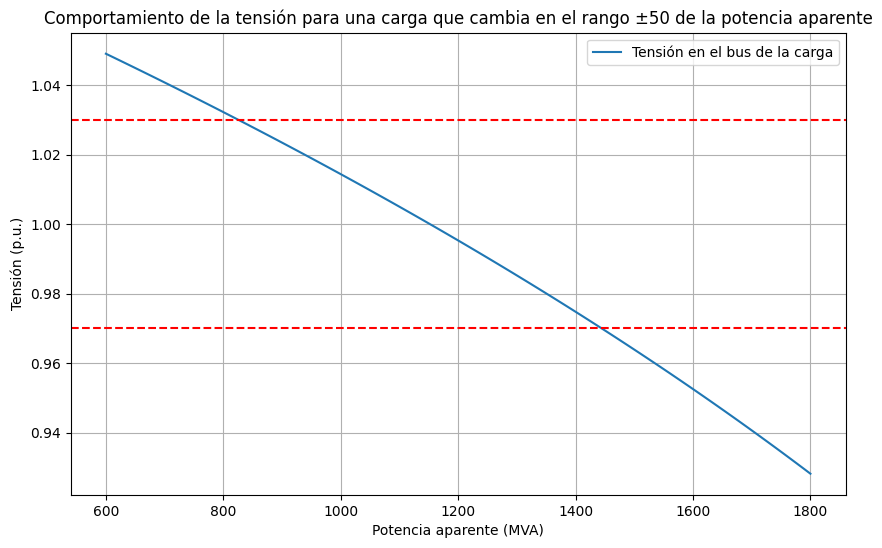

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


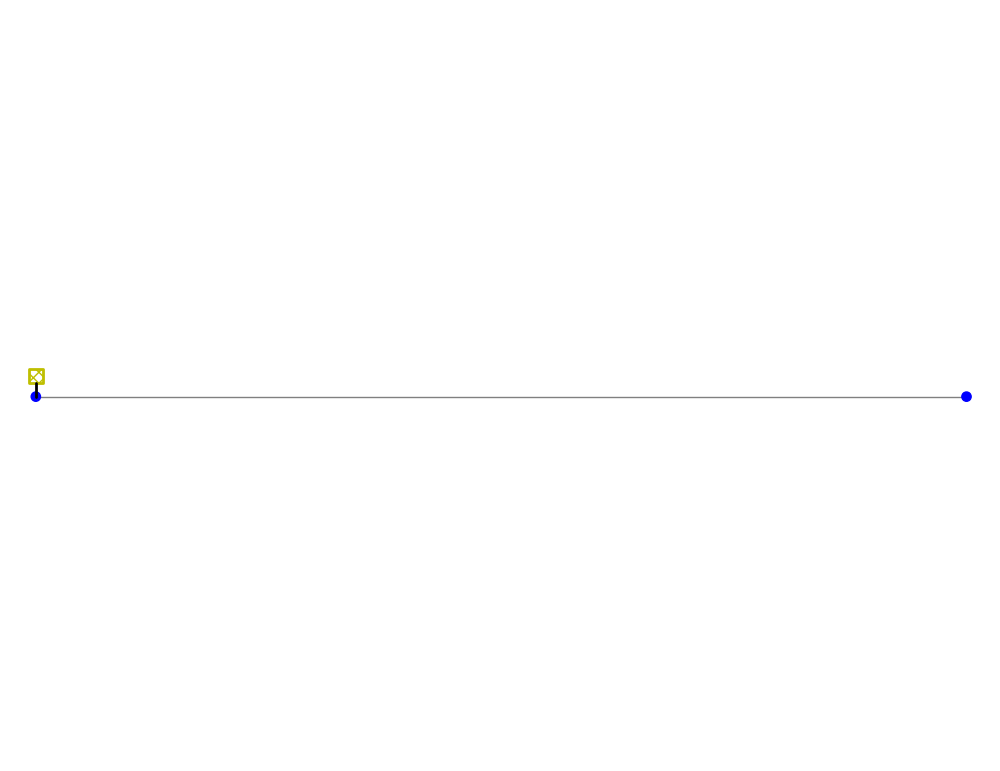

<Axes: >

In [1]:
import numpy
import scipy
import numba
import matplotlib
import matplotlib.pyplot as plt
import pandapower as pp
import pandapower.networks
import pandapower.topology
import pandapower.plotting
import pandapower.converter
import pandapower.estimation
import pandapower.plotting as pplot

#Crear red vacia (net)
net = pp.create_empty_network()
#Crear barras
line_data = {"r_ohm_per_km": 0.02, "x_ohm_per_km": 0.115, "c_nf_per_km": 19.1, "max_i_ka": 1., "type": "linea"}
pp.create_std_type(net, line_data, "linea")
b1 = pp.create_bus(net, vn_kv=500., name="Bus 1")
b2 = pp.create_bus(net, vn_kv=500, name="Bus 2")
pp.create_ext_grid(net, bus=b1, vm_pu=1, name="Conexion de malla");
pp.create_load(net, bus=b2, p_mw=1080, q_mvar=523.069, name="Carga");
#Crear linea
pp.create_line(net, from_bus=b1, to_bus=b2, length_km=500, std_type="linea", name="Linea 1", parallel=2)

# Potencia aparente inicial
s_initial = 1200  # en MVA
fp = 0.9  # factor de potencia

# Calcular la potencia activa y reactiva
p_initial = s_initial * fp  # en MW
q_initial = numpy.sqrt(s_initial**2 - p_initial**2)  # en MVar

# Crear un rango de potencias aparentes que represente el cambio de ±50%
s_range = numpy.linspace(s_initial*0.5, s_initial*1.5, num=100)

# Lista para guardar las tensiones
voltages = []
# Para cada potencia aparente en el rango
for s in s_range:
    # Calcular la nueva potencia activa y reactiva
    p = s * fp
    q = numpy.sqrt(s**2 - p**2)
    
    # Actualizar la carga en la red
    net.load.loc[0, 'p_mw'] = p
    net.load.loc[0, 'q_mvar'] = q

    # Ejecutar una simulación de flujo de potencia
    pp.runpp(net, max_iteration=2000, tolerance_mva=1e-9)
    
    # Guardar la tensión en el bus de la carga
    voltages.append(net.res_bus.vm_pu[b2])

# Graficar la tensión en función de la potencia aparente
plt.figure(figsize=(10, 6))
plt.plot(s_range, voltages, label='Tensión en el bus de la carga')

# Agregar las líneas en el eje y en los valores 0.97 y 1.03
plt.axhline(y=0.97, color='r', linestyle='--')
plt.axhline(y=1.03, color='r', linestyle='--')

plt.xlabel('Potencia aparente (MVA)')
plt.ylabel('Tensión (p.u.)')
plt.title('Comportamiento de la tensión para una carga que cambia en el rango ±50 de la potencia aparente')
plt.legend()
plt.grid(True)
plt.show()
pp.plotting.simple_plot(net)




In [2]:
#Visualizar
net.res_bus #Visualizar resultados de barras


,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-1681.366042,258.821742
1,0.928206,-11.404131,1620.000000,784.601810


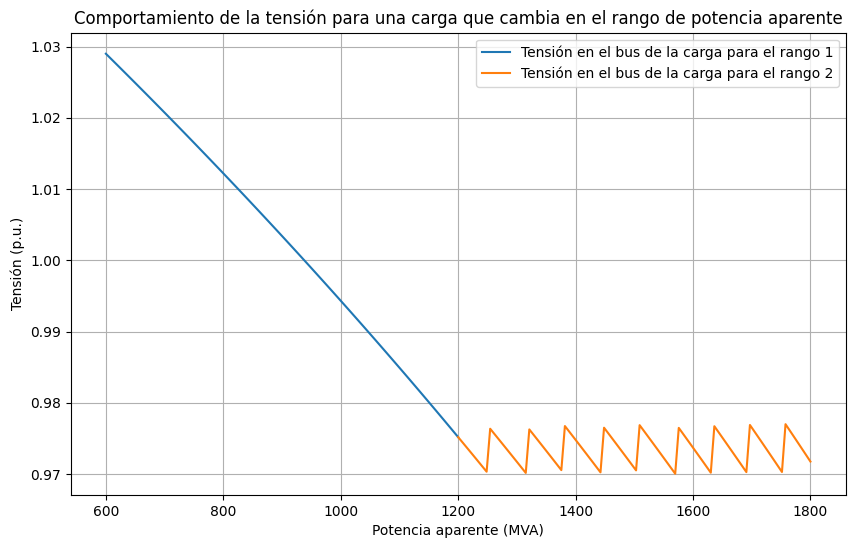

Para el rango de potencia aparente 2, se utilizaron los siguientes valores de compensación:
Potencia aparente: 1200.0, Compensación: 0
Potencia aparente: 1206.060606060606, Compensación: 0
Potencia aparente: 1212.121212121212, Compensación: 0
Potencia aparente: 1218.1818181818182, Compensación: 0
Potencia aparente: 1224.2424242424242, Compensación: 0
Potencia aparente: 1230.3030303030303, Compensación: 0
Potencia aparente: 1236.3636363636363, Compensación: 0
Potencia aparente: 1242.4242424242425, Compensación: 0
Potencia aparente: 1248.4848484848485, Compensación: 0
Potencia aparente: 1254.5454545454545, Compensación: -50
Potencia aparente: 1260.6060606060605, Compensación: -50
Potencia aparente: 1266.6666666666667, Compensación: -50
Potencia aparente: 1272.7272727272727, Compensación: -50
Potencia aparente: 1278.7878787878788, Compensación: -50
Potencia aparente: 1284.8484848484848, Compensación: -50
Potencia aparente: 1290.909090909091, Compensación: -50
Potencia aparente: 1296.96969

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandapower as pp

# Rangos de potencia aparente
s_ranges = [np.linspace(600, 1200, num=100), np.linspace(1200, 1800, num=100)]

# Crear una figura para la gráfica
plt.figure(figsize=(10, 6))

# Lista para guardar los valores de compensación
compensation_values = []

# Para cada rango de potencia aparente
for i, s_range in enumerate(s_ranges):
    # Lista para guardar las tensiones
    voltages = []
    
    # Lista para guardar los valores de compensación para cada s en el rango
    compensation_values_for_range = []

    # Crear compensación shunt
    compensation_value = 0  # Valor inicial de compensación en Mvar
    pp.create_shunt(net, bus=b2, q_mvar=compensation_value, p_mw=0, name=f"Compensacion_{i}")

    # Para cada potencia aparente en el rango
    for s in s_range:
        # Calcular la nueva potencia activa y reactiva
        p = s * fp
        q = np.sqrt(s**2 - p**2)
        
        # Actualizar la carga en la red
        net.load.loc[0, 'p_mw'] = p
        net.load.loc[0, 'q_mvar'] = q

        # Ajustar la compensación hasta que la tensión esté en el rango [0.97, 1.03]
        while True:
            # Ejecutar una simulación de flujo de potencia
            pp.runpp(net, max_iteration=2000, tolerance_mva=1e-9)
            
            # Verificar si la tensión está en el rango [0.97, 1.03]
            if 0.97 <= net.res_bus.vm_pu[b2] <= 1.03:
                break
            
            # Ajustar la compensación
            if net.res_bus.vm_pu[b2] < 0.97:
                # Necesita compensación capacitiva, ajustar en pasos de 10 Mvar
                compensation_value -= 50
            elif net.res_bus.vm_pu[b2] > 1.03:
                # Necesita compensación inductiva, ajustar en pasos de 10 Mvar
                compensation_value += 50
            
            # Actualizar la compensación en la red
            net.shunt.loc[i, 'q_mvar'] = compensation_value

        # Guardar la tensión en el bus de la carga
        voltages.append(net.res_bus.vm_pu[b2])
        
        # Guardar el valor de compensación para este s
        compensation_values_for_range.append(compensation_value)

    # Guardar los valores de compensación para este rango
    compensation_values.append(compensation_values_for_range)

    # Graficar la tensión en función de la potencia aparente
    plt.plot(s_range, voltages, label=f'Tensión en el bus de la carga para el rango {i+1}')

# Configurar la gráfica
plt.xlabel('Potencia aparente (MVA)')
plt.ylabel('Tensión (p.u.)')
plt.title('Comportamiento de la tensión para una carga que cambia en el rango de potencia aparente')
plt.legend()
plt.grid(True)
plt.show()

# Imprimir los valores de compensación
for i, compensation_values_for_range in enumerate(compensation_values):
    if i == 1:  # Solo para el rango 2
        print(f"Para el rango de potencia aparente {i+1}, se utilizaron los siguientes valores de compensación:")
        for s, compensation_value in zip(s_ranges[i], compensation_values_for_range):
            print(f"Potencia aparente: {s}, Compensación: {compensation_value}")


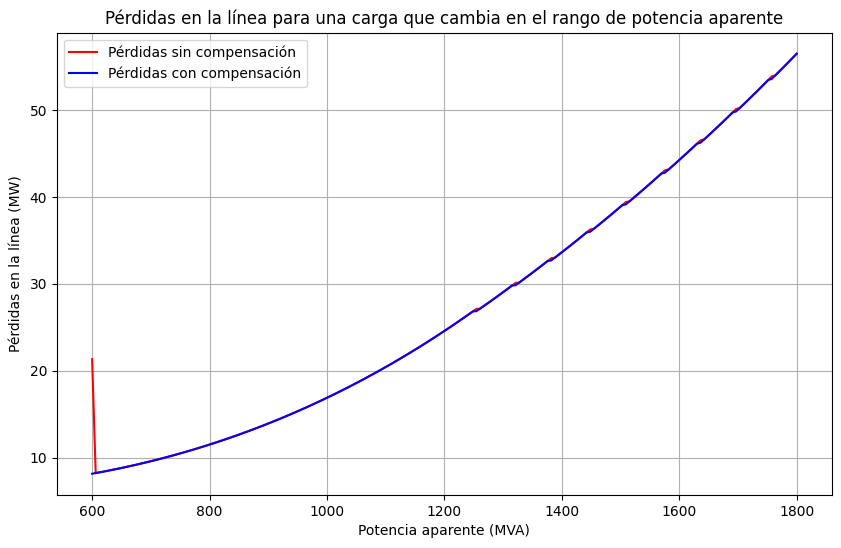

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandapower as pp

# Rangos de potencia aparente
s_ranges = [np.linspace(600, 1200, num=100), np.linspace(1200, 1800, num=100)]

# Listas para guardar las pérdidas en la línea para cada s en todos los rangos
line_losses_uncompensated = []
line_losses_compensated = []

# Para cada rango de potencia aparente
for i, s_range in enumerate(s_ranges):
    # Para cada potencia aparente en el rango
    for s in s_range:
        # Calcular la nueva potencia activa y reactiva
        p = s * fp
        q = np.sqrt(s**2 - p**2)
        
        # Actualizar la carga en la red
        net.load.loc[0, 'p_mw'] = p
        net.load.loc[0, 'q_mvar'] = q

        # Ejecutar una simulación de flujo de potencia sin compensación
        pp.runpp(net, max_iteration=2000, tolerance_mva=1e-9)
        
        # Calcular las pérdidas en la línea sin compensación
        line_loss_uncompensated = sum(net.res_line.pl_mw)
        
        # Guardar las pérdidas en la línea sin compensación para este s
        line_losses_uncompensated.append(line_loss_uncompensated)

        # Crear compensación shunt
        compensation_value = 0  # Valor inicial de compensación en Mvar
        pp.create_shunt(net, bus=b2, q_mvar=compensation_value, p_mw=0, name=f"Compensacion_{i}")

        # Ajustar la compensación hasta que la tensión esté en el rango [0.97, 1.03]
        while True:
            # Ejecutar una simulación de flujo de potencia con compensación
            pp.runpp(net, max_iteration=2000, tolerance_mva=1e-9)
            
            # Verificar si la tensión está en el rango [0.97, 1.03]
            if 0.97 <= net.res_bus.vm_pu[b2] <= 1.03:
                break
            
            # Ajustar la compensación
            if net.res_bus.vm_pu[b2] < 0.97:
                # Necesita compensación capacitiva, ajustar en pasos de 10 Mvar
                compensation_value -= 50
            elif net.res_bus.vm_pu[b2] > 1.03:
                # Necesita compensación inductiva, ajustar en pasos de 10 Mvar
                compensation_value += 50
            
            # Actualizar la compensación en la red
            net.shunt.loc[i, 'q_mvar'] = compensation_value

        # Calcular las pérdidas en la línea con compensación
        line_loss_compensated = sum(net.res_line.pl_mw)
        
        # Guardar las pérdidas en la línea con compensación para este s
        line_losses_compensated.append(line_loss_compensated)

# Unir los rangos de potencia aparente
s_range = np.concatenate(s_ranges)

# Crear una figura para la gráfica
plt.figure(figsize=(10, 6))

# Graficar las pérdidas en la línea en función de la potencia aparente sin compensación
plt.plot(s_range, line_losses_uncompensated, label='Pérdidas sin compensación', color='red')

# Graficar las pérdidas en la línea en función de la potencia aparente con compensación
plt.plot(s_range, line_losses_compensated, label='Pérdidas con compensación', color='blue')

# Configurar la gráfica
plt.xlabel('Potencia aparente (MVA)')
plt.ylabel('Pérdidas en la línea (MW)')
plt.title('Pérdidas en la línea para una carga que cambia en el rango de potencia aparente')
plt.legend()
plt.grid(True)
plt.show()